# CMP: Bonus Analyses

In [ ]:
NOT_LINUX = False  # set to True, if you have trouble replicating results with your operating system

In [1]:
import numpy as np
import pandas as pd

import umap
import hdbscan

import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

import os

/home/alina/anaconda3/envs/umap_hdbscan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EMBEDDINGS = 'data/'

if not os.path.exists(f'bonus'):
    os.makedirs(f'bonus')

PATH = f'bonus/'

In [3]:
### FINAL UMAP PARAMETERS ###
N_NEIGHBORS = 30
MIN_DIST = 0.01
N_COMPONENTS = 30
METRIC_UMAP = 'cosine'
RANDOM_STATE = 86531

### FINAL HDBSCAN PARAMETERS ###
MIN_CLUSTER_SIZE = 10
MIN_SAMPLES = 30
METRIC_HDBSCAN = 'euclidean'

### Load strategy texts & embeddings

In [4]:
# load raw strategy sentences
data = pd.read_csv(EMBEDDINGS + 'strategies_raw.csv', sep=';')
strategies = data['strategy text'].tolist()

In [5]:
# load strategy embeddings and convert to numpy array
strategy_embeddings = np.load(EMBEDDINGS + 'strategy_embeddings_masked.npy')

### Compute final UMAP & HDBSCAN combination

In [6]:
# perform UMAP embedding and HDBSCAN clustering
if NOT_LINUX == True:
    umap_embed_fin = np.load(EMBEDDINGS + f'not_linux/umap_embeddings_seed-{RANDOM_STATE}-(final).npy')
else:
    umap_fin = umap.UMAP(n_neighbors=N_NEIGHBORS,
                         min_dist=MIN_DIST,
                         n_components=N_COMPONENTS,
                         metric=METRIC_UMAP,
                         random_state=RANDOM_STATE).fit(strategy_embeddings)

    umap_embed_fin = umap_fin.transform(strategy_embeddings)

hdbscan_fin = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE,
                              min_samples=MIN_SAMPLES,
                              metric=METRIC_HDBSCAN,
                              prediction_data=True)

hdbscan_fin.fit(umap_embed_fin)

# cross-check number of clusters (37) & unclustered points (3067)
print(f'Number of clusters: {max(hdbscan_fin.labels_ + 1)}')
print(f'Number of unclustered points: {list(hdbscan_fin.labels_).count(-1)}')

Number of clusters: 37
Number of unclustered points: 3067


### Inspect number of sentences per cluster

In [7]:
print('No. of sentences per cluster')
print(pd.Series(hdbscan_fin.labels_).value_counts().sort_values(ascending=False))

No. of sentences per cluster
-1     3067
 23     195
 33     194
 17     190
 4      174
 0      159
 19     134
 21     120
 7      120
 3      116
 24     112
 10     108
 14      97
 5       97
 9       86
 25      79
 6       76
 16      71
 13      61
 1       61
 2       61
 29      59
 28      51
 18      49
 35      48
 34      43
 8       43
 11      42
 32      42
 27      41
 31      39
 20      38
 30      36
 22      35
 15      32
 12      31
 26      27
 36      12
dtype: int64


### Plot item distributions over clusters

In [8]:
# compute frequency of items for each cluster
no_clusters = max(hdbscan_fin.labels_ + 1)

item_distrib = []

for no in range(no_clusters):
    item_labels = np.delete(data.item.tolist(), np.where(hdbscan_fin.labels_ != no), axis=0).tolist()
    item_distrib.append([item_labels.count(i) for i in range(1, 10)])

In [9]:
# instantiate colormap with 9 colors
cmap = plt.get_cmap('Set1')
hex_colors = [rgb2hex(cmap(i)) for i in range(cmap.N)]

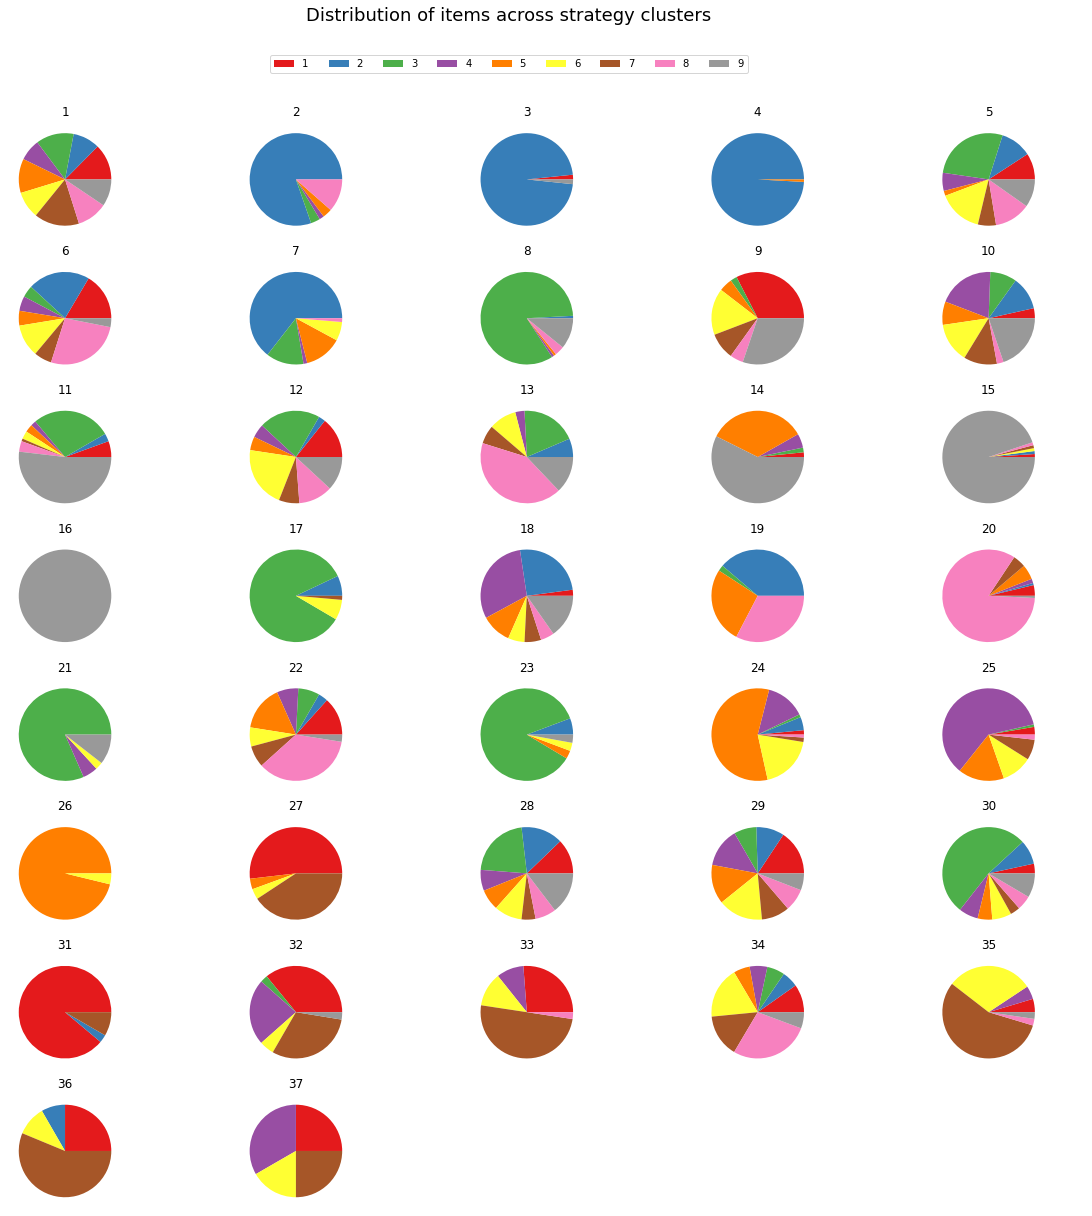

In [10]:
# plot items per cluster
SUBPLOTS = (8, 5)

fig, axs = plt.subplots(SUBPLOTS[0], SUBPLOTS[1], figsize=(20, 20))

index = 0
for i in range(SUBPLOTS[0]):
    for j in range(SUBPLOTS[1]):
        try:
            axs[i,j].pie(item_distrib[index], colors=hex_colors)
            axs[i,j].set_title(f'{index+1}')
            index += 1
        except IndexError:
            axs[i,j].axis('off')
fig.legend(labels=range(1, 10), loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=9)
fig.suptitle(f'Distribution of items across strategy clusters', fontsize=18, x=0.5, y=0.96)
fig.savefig(PATH + f'dist_items_in_clusters.svg')

### Plot cluster distributions over items

In [11]:
# compute frequency of clusters for each item
cluster_distrib = []

for i in range(1, 10):
    clusters = np.delete(hdbscan_fin.labels_, np.where(data.item != i), axis=0).tolist()
    cluster_distrib.append([clusters.count(k) for k in range(0, no_clusters)])

In [12]:
# instantiate colormaps with 39 colors
cmap1 = plt.get_cmap('tab20b')
cmap2 = plt.get_cmap('tab20c')
hex_colors1 = [rgb2hex(cmap1(i)) for i in range(cmap1.N)]
hex_colors1 = hex_colors1 + [rgb2hex(cmap2(i)) for i in range(cmap2.N)]
del hex_colors1[-1]

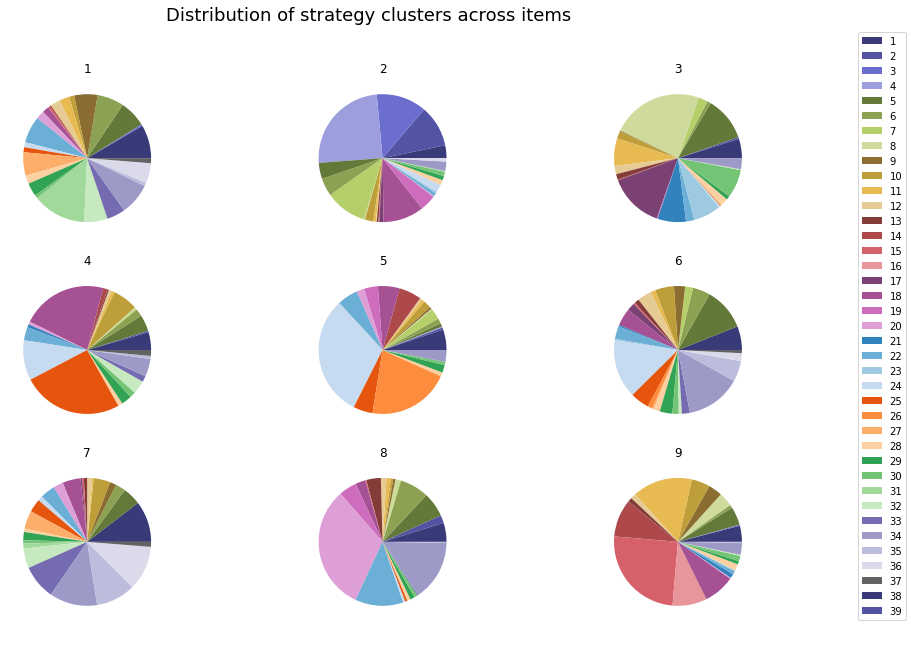

In [13]:
# plot clusters per item
SUBPLOTS = (3, 3)

fig, axs = plt.subplots(SUBPLOTS[0], SUBPLOTS[1], figsize=(15, 10))

index = 0
for i in range(SUBPLOTS[0]):
    for j in range(SUBPLOTS[1]):
        axs[i,j].pie(cluster_distrib[index], colors=hex_colors1)
        axs[i,j].set_title(f'{index+1}')
        index += 1
fig.legend(labels=range(1, 40), loc='center right')
fig.suptitle('Distribution of strategy clusters across items', fontsize=18)
fig.savefig(PATH + f'dist_clusters_in_items.svg')

### Plot number of unclustered sentences across items

In [14]:
# compute number of unclustered sentences for each item
no_unclustered = []

for i in range(1, 10):
    clusters = np.delete(hdbscan_fin.labels_, np.where(data.item != i), axis=0).tolist()
    no_unclustered.append(clusters.count(-1))

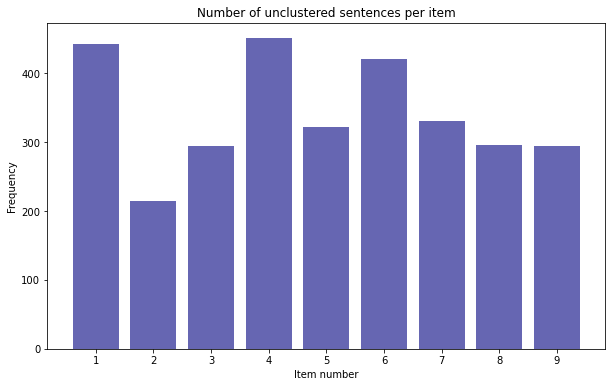

In [15]:
fig = plt.figure(figsize=(10, 6))

plt.bar(np.arange(9), no_unclustered, align='center',color='navy', alpha=0.6)
plt.xticks(np.arange(9), np.arange(1, 10))
plt.xlabel('Item number')
plt.ylabel('Frequency')
plt.title('Number of unclustered sentences per item')

plt.show()

fig.savefig(PATH + f'unclustered_vs_items.svg')